# Parameter Recovery

- Simulate data from Dual Learning Rate agents with known parameters
- Estimate parameters from simulated data
- Compare recovered vs true parameters

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import myplotlib as my

from agent_rl import (
    AgentVars,
    DualLearningRateAgent,
    TaskVars,
    ReversalLearningTask,
    agent_task_interaction,
    EstimationVars,
    Estimation,
)

## 1. Set up Reversal Learning Task

- 2 options, 2 hidden states
- State 0: option 0 has 80% reward, option 1 has 20%
- State 1: option 0 has 20% reward, option 1 has 80%
- Reversal after 8-12 correct trials (min 80% accuracy)

In [2]:
task_vars = TaskVars(
    n_options=2,
    n_blocks=4,
    n_trials=100,
)

task_vars.states = {
    0: {"p_r": [0.8, 0.2], "rewards": [1, 0], "a_correct": [0]},
    1: {"p_r": [0.2, 0.8], "rewards": [1, 0], "a_correct": [1]},
}

task_vars.n_trials_reversal_min = 8
task_vars.n_trials_reversal_max = 12
task_vars.p_correct_reversal_min = 0.8

print("Task configuration:")
print(f"  - {task_vars.n_blocks} blocks x {task_vars.n_trials} trials = {task_vars.n_blocks * task_vars.n_trials} total")
print(f"  - Reversal after {task_vars.n_trials_reversal_min}-{task_vars.n_trials_reversal_max} trials")
print(f"  - Reversal criterion: {task_vars.p_correct_reversal_min*100:.0f}% accuracy")
print(f"  - Episodes start new with every new block (Q-values should be reset)")

Task configuration:
  - 4 blocks x 100 trials = 400 total
  - Reversal after 8-12 trials
  - Reversal criterion: 80% accuracy
  - Episodes start new with every new block (Q-values should be reset)


## 2. Set up Dual Learning Rate Agents

- 50 simulated agents
- Parameters drawn from uniform distributions:
  - α+ ~ U(0.1, 0.9)
  - α- ~ U(0.1, 0.9)
  - β ~ U(1, 10)

In [3]:
np.random.seed(38)

n_agents = 50

true_params = pd.DataFrame({
    'agent': range(n_agents),
    'alpha_pos': np.random.uniform(0.1, 0.9, n_agents),
    'alpha_neg': np.random.uniform(0.1, 0.9, n_agents),
    'beta': np.random.uniform(1, 10, n_agents),
})

print(f"Generated {n_agents} parameter sets")
print(f"\nParameter ranges:")
print(f"  α+: [{true_params['alpha_pos'].min():.2f}, {true_params['alpha_pos'].max():.2f}]")
print(f"  α-: [{true_params['alpha_neg'].min():.2f}, {true_params['alpha_neg'].max():.2f}]")
print(f"  β:  [{true_params['beta'].min():.2f}, {true_params['beta'].max():.2f}]")

true_params.head(10)

Generated 50 parameter sets

Parameter ranges:
  α+: [0.11, 0.89]
  α-: [0.12, 0.87]
  β:  [1.33, 9.99]


,agent,alpha_pos,alpha_neg,beta
0,0,0.407818,0.482990,9.035352
1,1,0.787766,0.434164,3.126576
2,2,0.855360,0.335850,2.896104
3,3,0.662260,0.555606,4.205367
4,4,0.606907,0.390629,5.685727
5,5,0.584769,0.300056,6.262391
6,6,0.260101,0.453499,6.510350
7,7,0.409910,0.581014,3.657955
8,8,0.307187,0.363566,1.929353
9,9,0.159686,0.618652,9.990741


## 3. Simulate Data

- Run each agent on the reversal learning task
- Store behavioral data for parameter estimation

In [4]:
all_sim_data = []

for i, row in true_params.iterrows():
    print(f"  Simulating agent {i+1}/{n_agents}...", end='\r')

    agent_vars = AgentVars(
        alpha_pos=row['alpha_pos'],
        alpha_neg=row['alpha_neg'],
        beta=row['beta'],
    )
    # n_states=1: agent doesn't observe hidden task states
    agent_vars.Q_init = np.ones((1, 2)) * 0.5
    agent_vars.reset_q_each_block = True

    agent = DualLearningRateAgent(
        agent_vars,
        n_options=2,
        n_states=1,
        variant='delta',
    )

    task = ReversalLearningTask(task_vars)

    sim_data = agent_task_interaction(task, agent)
    sim_data['agent'] = i
    all_sim_data.append(sim_data)

print(f"  Simulated {n_agents} agents.")

all_sim_data = pd.concat(all_sim_data, ignore_index=True)
print(f"\nTotal simulated trials: {len(all_sim_data)}")

  Simulated 50 agents.50...

Total simulated trials: 20000


## 4. Estimate Parameters

- Fit Dual Learning Rate model to each agent's data
- Use 5 random starting points

In [5]:
est_vars = EstimationVars(
    task_vars=task_vars,
    agent_class=DualLearningRateAgent,
    parameters=['alpha_pos', 'alpha_neg', 'beta'],
    bounds={
        'alpha_pos': (0.0, 1.0),
        'alpha_neg': (0.0, 1.0),
        'beta': (0.1, 20.0),
    },
    n_sp=5,
    rand_sp=True,
    reset_q_each_block=True,
    variant='delta',
)

recovered_params = []

for i in range(n_agents):
    print(f"  Fitting agent {i+1}/{n_agents}...", end='\r')

    agent_data = all_sim_data[all_sim_data['agent'] == i].copy()
    agent_data = agent_data.rename(columns={'a': 'a', 's': 's', 'r': 'r'})

    agent_vars = AgentVars()
    # n_states=1: agent doesn't observe hidden task states
    agent_vars.Q_init = np.ones((1, 2)) * 0.5

    estimator = Estimation(est_vars)
    nll, bic, params, _ = estimator.estimate(agent_data, agent_vars=agent_vars, seed=i*100)

    recovered_params.append({
        'agent': i,
        'alpha_pos_rec': params[0],
        'alpha_neg_rec': params[1],
        'beta_rec': params[2],
        'nll': nll,
        'bic': bic,
    })

print(f"  Fitted {n_agents} agents.          ")

recovered_params = pd.DataFrame(recovered_params)

  Fitted 50 agents.          


## 5. Compare True vs Recovered Parameters

- Overview table with correlations
- Scatter plots with regression lines
  - Correlations $r$ should be positive and high
  - Intercepts $\beta_0$ should be close to 0
  - Slopes $\beta_1$ should be close to 1

In [6]:
results = true_params.merge(recovered_params, on='agent')

from scipy.stats import pearsonr

corr_alpha_pos, p_alpha_pos = pearsonr(results['alpha_pos'], results['alpha_pos_rec'])
corr_alpha_neg, p_alpha_neg = pearsonr(results['alpha_neg'], results['alpha_neg_rec'])
corr_beta, p_beta = pearsonr(results['beta'], results['beta_rec'])

summary = pd.DataFrame({
    'Parameter': ['α+', 'α-', 'β'],
    'True (mean ± std)': [
        f"{results['alpha_pos'].mean():.3f} ± {results['alpha_pos'].std():.3f}",
        f"{results['alpha_neg'].mean():.3f} ± {results['alpha_neg'].std():.3f}",
        f"{results['beta'].mean():.2f} ± {results['beta'].std():.2f}",
    ],
    'Recovered (mean ± std)': [
        f"{results['alpha_pos_rec'].mean():.3f} ± {results['alpha_pos_rec'].std():.3f}",
        f"{results['alpha_neg_rec'].mean():.3f} ± {results['alpha_neg_rec'].std():.3f}",
        f"{results['beta_rec'].mean():.2f} ± {results['beta_rec'].std():.2f}",
    ],
    'Correlation (r)': [
        f"{corr_alpha_pos:.3f}",
        f"{corr_alpha_neg:.3f}",
        f"{corr_beta:.3f}",
    ],
    'p-value': [
        f"{p_alpha_pos:.2e}",
        f"{p_alpha_neg:.2e}",
        f"{p_beta:.2e}",
    ],
})

print("Parameter Recovery Summary")
print("=" * 80)
summary

Parameter Recovery Summary


,Parameter,True (mean ± std),Recovered (mean ± std),Correlation (r),p-value
0,α+,0.520 ± 0.227,0.481 ± 0.253,0.856,2.42e-15
1,α-,0.518 ± 0.188,0.527 ± 0.210,0.910,6.26e-20
2,β,5.76 ± 2.44,7.02 ± 3.75,0.771,6.01e-11


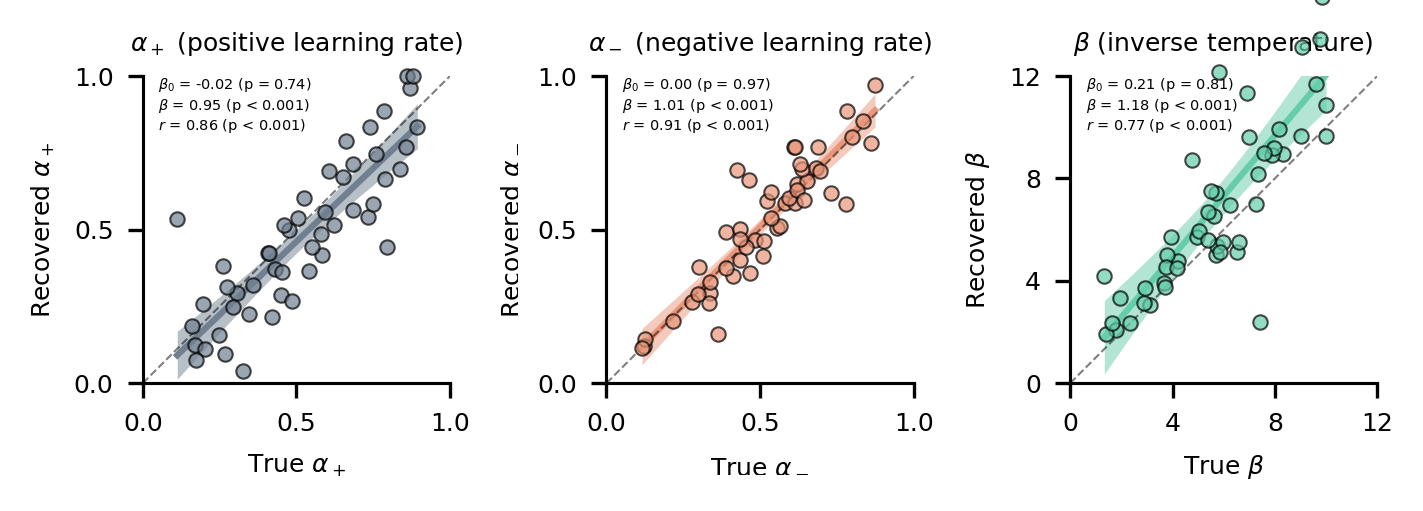

In [ ]:
# Parameter config: name, true_col, rec_col, label, bounds, ticks, color
param_config = [
    {
        'name': 'alpha_pos',
        'true_col': 'alpha_pos',
        'rec_col': 'alpha_pos_rec',
        'label': r'$\alpha_+$',
        'title': r'$\alpha_+$ (positive learning rate)',
        'bounds': (0, 1),
        'ticks': [0, 0.5, 1],
        'color': 'C0',
    },
    {
        'name': 'alpha_neg',
        'true_col': 'alpha_neg',
        'rec_col': 'alpha_neg_rec',
        'label': r'$\alpha_-$',
        'title': r'$\alpha_-$ (negative learning rate)',
        'bounds': (0, 1),
        'ticks': [0, 0.5, 1],
        'color': 'C1',
    },
    {
        'name': 'beta',
        'true_col': 'beta',
        'rec_col': 'beta_rec',
        'label': r'$\beta$',
        'title': r'$\beta$ (inverse temperature)',
        'bounds': (0, 12),
        'ticks': [0, 4, 8, 12],
        'color': 'C2',
    },
]

fig, axes = plt.subplots(1, 3, figsize=my.utilities.cm2inch((12, 4)))

for ax, cfg in zip(axes, param_config):
    x = results[cfg['true_col']].rename(f"True {cfg['label']}")
    y = results[cfg['rec_col']].rename(f"Recovered {cfg['label']}")

    my.plots.lm(x, y, ax=ax, annotate=['r', 'b0', 'b1'], color=cfg['color'])

    # Identity line
    ax.plot(cfg['bounds'], cfg['bounds'], 'k--', lw=0.5, alpha=0.5)

    # Set identical x and y limits and ticks
    ax.set_xlim(cfg['bounds'])
    ax.set_ylim(cfg['bounds'])
    ax.set_xticks(cfg['ticks'])
    ax.set_yticks(cfg['ticks'])
    ax.set_aspect('equal')
    ax.set_title(cfg['title'])

plt.tight_layout()